# Домашнее задание №2 - Линейные модели. Градиентный спуск

В этом домашнем задании мы с вами научимся обучать линейные модели регрессии и классификации при помощи очень мощного, но в то же время довольно понятного алгоритма, который называется **градиетный спуск**. Помимо линейных моделей он используется и для обучения самых сложных нейронных сетей! Также мы потренируемся применять готовые реализации линейных моделей для задач регрессии и бинарной классификации.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
import pandas as pd

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.exceptions import NotFittedError
from sklearn.linear_model import (LinearRegression,
                                  LogisticRegression)
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from sklearn.metrics import (r2_score,
                             mean_squared_error,
                             mean_absolute_error,
                             accuracy_score, 
                             precision_score, 
                             recall_score, 
                             f1_score, roc_auc_score,
                             confusion_matrix, roc_curve)
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer

In [2]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

#### Маленькое теоретическое отступление

Основное свойство антиградиента (-1 * градиент) &ndash; он указывает в сторону наискорейшего убывания функции в данной точке. Соответственно, будет логично стартовать из некоторой точки, сдвинуться в сторону антиградиента, пересчитать антиградиент и снова сдвинуться в его сторону и т.д. Запишем это более формально.

Пусть $w_0$ &ndash; начальный набор параметров (коэффициентов линейной модели) ((например, нулевой или сгенерированный из некоторого, случайного распределения)). Тогда обычный градиентный спуск состоит в повторении следующих шагов до сходимости:


$$
    w_{k + 1} = w_{k} - \eta \nabla_{w} Q(w_{k}),
$$

где $\nabla_{w} Q(w_{k})$ &ndash; градиент функции потерь в точке $w_k$, а $\eta$ &ndash; скорость обучения (learning rate).

Градиентный спуск обычно останавливают, когда прошло заданное максимальное количество итераций или когда графиент близок к нулю (т.е. наши параметры практически не меняются). Для реализации второго варианта считают норму градиента (по сути длину вектора). Это можно сделать несколькими способами:

$$
l1_{norm} = \sum{|w_i|}
$$

$$
l2_{norm} = \sum{(w_i)^{2}}
$$

Попробуем разобраться на простом примере. Рассмотрим функцию от двух переменных:
$f(x, y) = \sin^2 x + \sin^2 y$

In [3]:
def f(w):
    """
    :param w: np.array(np.float) вектор из 2-х элементов
    :return: np.float
    """
    
    return np.sum(np.sin(w)**2)

Обратите внимание, что $x$ - numpy-array вектор длины 2.

***Reminder:***  
Что мы хотим? Мы хотим найти минимум этой функции (в машинном обучении мы обычно хотим найти минимум **функции потерь**, например, MSE), а точнее найти $w_1$ и $w_2$ такие, что при них значение $f(w_1, w_2)$ минимально, то есть *точку экстремума*.  
  
Как мы будем искать эту точку? Используем методы оптимизации (в нашем случае - *минимизации*). Одним из таких методов и является **градиентный спуск**.

### Задание 1. Градиентный спуск для функции $f$ (1 балл)

Реализуйте функцию, которая будет осуществлять градиентный спуск для функции $f$:

*Примечание:* Вам нужно посчитать частные производные именно **аналитически** и **переписать их в код**, а не считать производные численно (через отношение приращения функции к приращению аргумента) -- в этих двух случаях могут различаться ответы, поэтому будьте внимательны.

In [4]:
def grad_f(w): 
    """
    Градиент функциии f, определенной выше.
        :param w: np.array[2]: float вектор из 2-х элементов
        :return: np.array[2]: float вектор из 2-х элементов
    """
    
    x, y = w
    dx = 2 * np.sin(x) * np.cos(x)
    dy = 2 * np.sin(y) * np.cos(y)
    return np.array([dx, dy])

Проверим, что градиент принимает вектор из двух чисел и выдает на этой точке верное значение

In [5]:
assert np.allclose(grad_f(np.array([1, 2])), 
                   np.array([0.90929743, -0.7568025])), "Что-то не так!"

In [6]:
def grad_descent_2d(f, grad_f, lr, num_iter=100, x0=None):
    """
    Функция, которая реализует градиентный спуск в минимум для функции f от двух переменных. 
        :param f: скалярная функция двух переменных
        :param grad_f: функция, возвращающая градиент функции f (устроена как реализованная вами выше grad_f)
        :param lr: learning rate алгоритма
        :param num_iter: количество итераций градиентного спуска
        :return: np.array[num_iter, 2] пар вида (x, f(x))
    """
    
    w0 = np.random.random(2)

    # будем сохранять значения аргументов и значений функции 
    # в процессе град. спуска в переменную history
    history = []

    # итерация цикла == шаг градиентнго спуска
    curr_w = w0.copy()
    for iter_num in range(num_iter):
        entry = np.hstack((curr_w, f(curr_w)))
        history.append(entry)
    
        curr_w -= lr * grad_f(curr_w)

    return np.vstack(history)

Визуализируем точки градиентного спуска на 3D-графике нашей функции. Звездочками будут обозначены точки (тройки $w_1, w_2, f(w_1, w_2)$), по которым Ваш алгоритм градиентного спуска двигался к минимуму (Для того, чтобы написовать этот график, мы и сохраняли значения $cur\_w_1, cur\_w_2, f(cur\_w_1, cur\_w_2)$ в `steps` в процессе спуска).

Если у Вас правильно написана функция `grad_descent_2d`, то звездочки на картинке должны сходиться к одной из точек минимума функции. Вы можете менять начальные приближения алгоритма, значения `lr` и `num_iter` и получать разные результаты.

In [7]:
def gradient_desc_vis(f, grad_f, lr=0.1, num_iter=20):
    steps = grad_descent_2d(f, grad_f, lr=lr, num_iter=num_iter)
    
    X, Y = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))

    fig = plt.figure(figsize=(16, 10))
    ax = fig.add_subplot(projection="3d")

    zs = np.array([f(np.array([x,y]))
                  for x, y in zip(np.ravel(X), np.ravel(Y))])
    Z = zs.reshape(X.shape)


    ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, zorder=2)

    ax.plot(xs=steps[:, 0], ys=steps[:, 1], zs=steps[:, 2],
            marker="*", markersize=20, zorder=3, 
            markerfacecolor="y", lw=3, c="black")

    ax.set_zlim(0, 5)
    ax.view_init(elev=60)
    plt.show()
    
    return steps

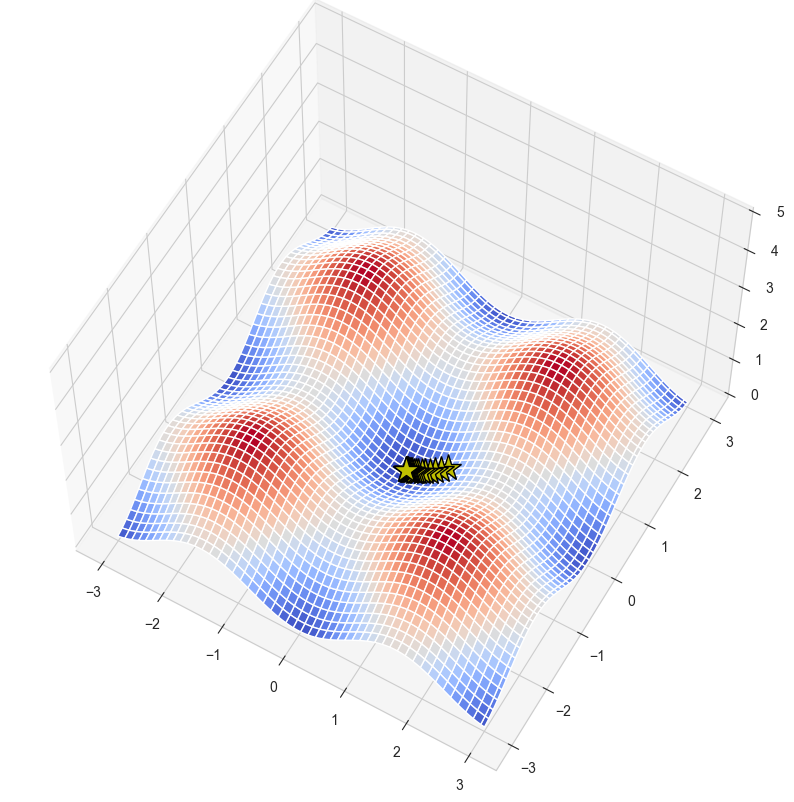

In [8]:
steps = gradient_desc_vis(f, grad_f)

Посмотрим на зависимость значения функции от шага градиентного спуска.

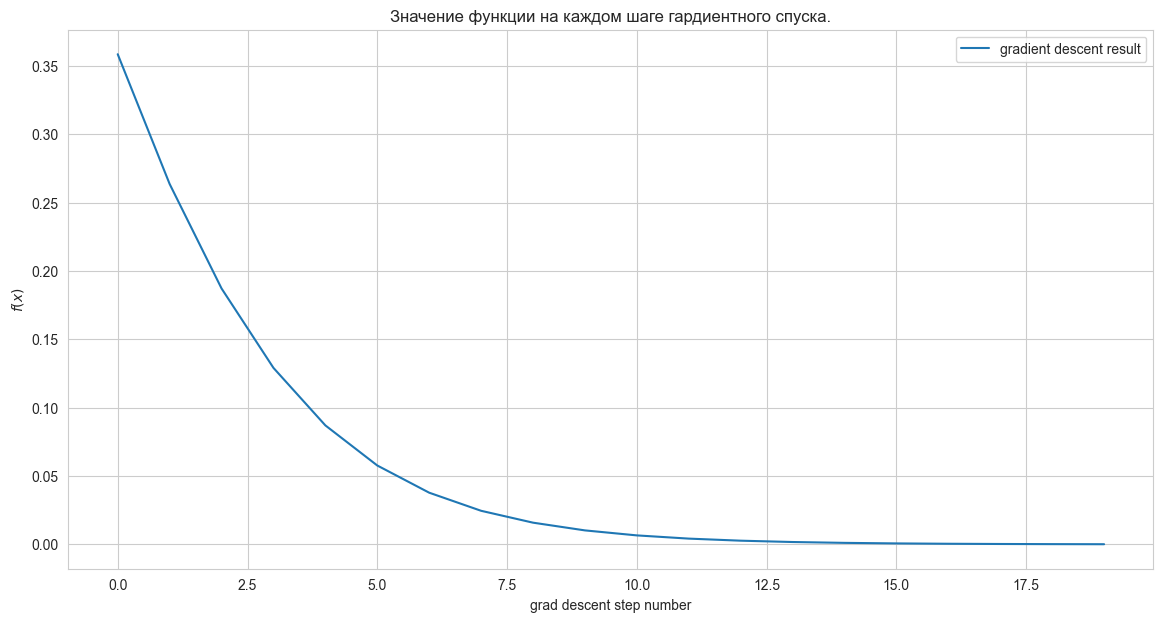

In [9]:
plt.figure(figsize=(14,7))
plt.xlabel("grad descent step number")
plt.ylabel("$f(x)$")
plt.title("Значение функции на каждом шаге гардиентного спуска.")

f_values = list(map(lambda x: x[2], steps))
plt.plot(f_values, label="gradient descent result")
plt.legend();

### Задание 2. Реализация линейной регресии (суммарно 9 баллов)

Так как мы будем использовать градиентный спуск для обучения модели, важной часть является реализация функции потерь и функции для расчета ее градиента. Перем началом стоит напомнить, как считать градиент MSE. Вывод этой формулы можно найти  [здесь](https://medium.com/analytics-vidhya/linear-regression-gradient-descent-intuition-and-math-c9a8f5aeeb22)

$$
    MSE = \frac{1}{N}\sum(y_{true} - y_{pred}) ^ 2
$$

$$
    \nabla{MSE} = \frac{2}{N} X^T (y_{pred} - y_{true})
$$

Здесь имеется в виду именно матричное умножение.

#### Задание 2.1. MSE и ее градиент (2 балла)

In [10]:
def mse(y_true, y_pred):
    """
    Функция потерь MSE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    mse_value = np.mean((y_true - y_pred)**2)
    return mse_value


def mse_grad(y_true, y_pred, X):
    """
    Функция для расчета градиента MSE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели
        :param X: np.array[n_samples, n_features]: матрица объекты x признаки
        :return: градиент функции потерь MSE
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    n_samples = len(y_true)
    error = y_true - y_pred
    gradient = -(2 / n_samples) * np.dot(X.T, error)
    
    return gradient


class MSELoss:
    """
    Класс, реализующий функцию потерь MSE. Нужен для того, чтобы
    объединять в одном месте функцию потерь и градиент для нее.
    """
    
    def __call__(self, y_true, y_pred):
        return mse(y_true, y_pred)
    
    def calculate_gradient(self, y_true, y_pred, X):
        return mse_grad(y_true, y_pred, X)

Мы будем использовать следующий класс для расчета градиента наших функций потерь:

In [11]:
class BasicGradientDescent:
    """
    Класс, позволяющий делать шаги градиентного спуска,
    а также рассчитывающих норму градиента.
    """
    
    def __init__(self, loss_function, grad_norm):
        self.loss = loss_function
        self.grad_norm = grad_norm
        
    
    def step(self, y, y_pred, X):
        grad_i = self.loss.calculate_gradient(y, y_pred, X)
        grad_i_norm = self._calculate_grad_norm(grad_i)
        
        return grad_i, grad_i_norm
            
            
    def _calculate_grad_norm(self, grad_i):
        if self.grad_norm == "l1":
            return np.abs(grad_i).sum()
        elif self.grad_norm == "l2":
            return np.sqrt(np.square(grad_i).sum())
        else:
            raise ValueError(f"I can't calculate {self.grad_norm} norm of gradient")

В данном задании нужно будет реализовать линейную регрессию и обучить ее при помощи градиентного спуска. Для этого нужно будет заполнять пропуски кода в соответствующих классах. Для начала мы реализуем базовый класс для всех линейных моделей, от которого потом будем наследоваться при реализации линейной и логистической регресий. Не переживайте, этот класс уже реализован, вам достостаточно просто разобраться с кодом.

In [12]:
class BaseLinearModel:
    """
    Класс, который представляет из себя базовую линейную модель, наследуюясь от которого, мы будем
    реализовывать линейную и логистическую регрессии.
    """
    
    def __init__(self, learning_rate, 
                 loss_function, fit_intercept,
                 n_iter, tol, optimizer, grad_norm):
        """
        Конструктор нашего класса. 
            :param learning_rate: скорость обучения
            :param loss_function: функция потерь (MSE или кросс-энтропия)
            :param fit_intercept: нужно ли нам включать свободных член в модель
            :param n_iter: количество итераций градиентного спуска
            :param tol: параметр для остановки градиентного спуска,
                        если норма градиента (l1 или l2) меньше tol, то останавливаемся
            :param optimizer: класс, который будет рассчитывать градиент и его норму
            :param grad_norm: тип нормы градиента l1 или l2
        """
        
        self.learning_rate = learning_rate
        self.loss = loss_function
        self.fit_intercept = fit_intercept
        self.n_iter = n_iter
        self.tol = tol
        self.grad_norm = grad_norm
        self.optimizer = optimizer(loss_function, grad_norm)
        
        # В начале параметры модели не заданы
        self.W = None
        
        
    def fit(self, X, y):
        """
        Метод для обучения нашей модели 
            :param X: матрица объекты x признаки
            :param y: вектор значений целевой переменной
            :return: обученная модель
        """
        
        # Сделаем из y вектор-столбец (n_samples, 1)
        y = y.reshape(-1, 1)
        n_samples = X.shape[0]
        
        # Добавим колонку из 1 в матрицу X
        if self.fit_intercept:
            ones_column = np.ones((n_samples, 1))
            X_new = np.hstack((ones_column, X))
        
        n_features = X_new.shape[1]
        
        # Инициализируем веса модели
        if self.W is None:
            self.W = np.random.randn(n_features, 1)
        
        # Обучаем модель градиентным спуском
        for i in range(self.n_iter):
            y_pred = self.predict(X)
            grad_i, grad_i_norm = self.optimizer.step(y, y_pred, X_new)
            
            # Если градиент близок к 0, останавливаемся
            if grad_i_norm <= self.tol:
                return self
            
            else:
                self.W -= self.learning_rate * grad_i
        
        return self
    
    
    def predict(self, X):
        raise NotImplementedError("It is a basic class for all linear models. You should implement it for descendant class.")
    
    
    def __repr__(self):
        return "Base linear model without prediction skill :("

#### Задание 2.2. Предсказания линейной регрессии (3 балла)

Реализуйте метод `predict` у класса `CustomLinearRegression`, не забудьте про свободный член!

In [13]:
class CustomLinearRegression(BaseLinearModel):
    def __init__(self, learning_rate: float = 1e-2, 
                 loss_function=MSELoss(), fit_intercept=True,
                 n_iter=1000, tol=1e-5, optimizer=BasicGradientDescent, grad_norm="l1"):
        
        # Если вы не проходили наследование и в частности `super`, то не страшно
        # коротко, с помощью этого мы можем вызывать методы родительского класса
        # в частности здесь мы используем метод `init`
        super().__init__(learning_rate=learning_rate, 
                         loss_function=loss_function, fit_intercept=fit_intercept,
                         n_iter=n_iter, tol=tol, optimizer=optimizer, grad_norm=grad_norm)
        
    
    def predict(self, X_test):
        """
        Метод для вычисления предсказаний 
            :param X_test: np.array[n_test_samples, n_features]: 
                           матрица объекты x признаки (тестовый датасет)
            :return: y_pred: np.array[n_test_samples, 1]: предсказания модели
        """
        
        if self.W is None:
            raise NotFittedError("This CustomLinearRegression instance is not fitted yet, run fit method.")
        
        n_test_samples = X_test.shape[0]
        if self.fit_intercept:
            ones_column = np.ones((n_test_samples, 1))
            X_test = np.hstack((ones_column, X_test))
        
            
        return np.dot(X_test, self.W)
    
    
    def __repr__(self):
        return "My custom linear regression"

##### Проверим нашу реализацию на простом примере

In [14]:
X = np.random.randn(100, 1)
y = 2 * X + 5 + 0.5 * np.random.randn(100, 1)

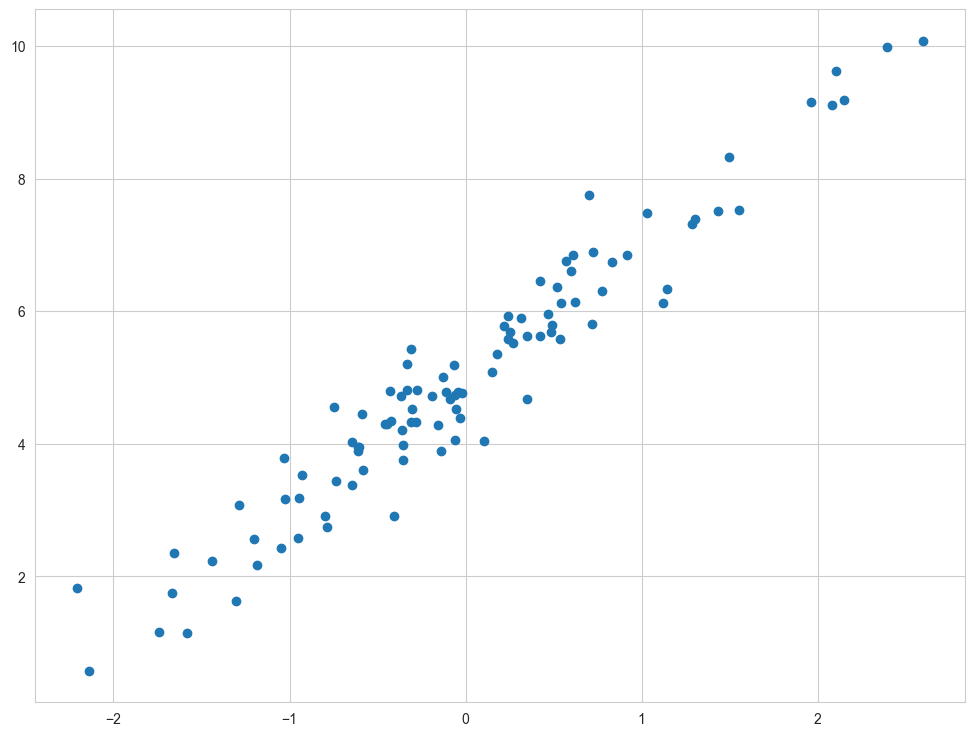

In [15]:
plt.scatter(X, y);

In [16]:
custom_lin_reg = CustomLinearRegression()

In [17]:
custom_lin_reg.fit(X, y)

My custom linear regression

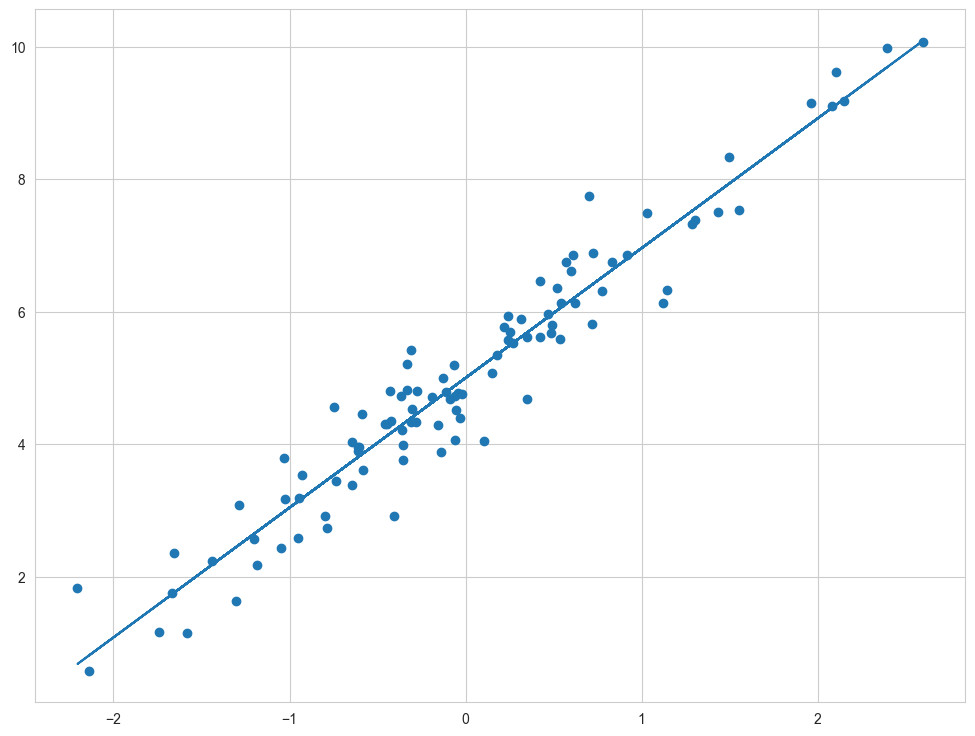

In [18]:
plt.scatter(X, y)
plt.plot(X, custom_lin_reg.predict(X));

#### Задание 2.3. Используем встроенную линейную регрессию (4 балла)

Поработаем с данными о ценах на дома в Калифорнии. Постройте модель линейной регресии при помощи `LinearRegression` из `sklearn`. Не забудьте разделить данные на тренировочную и тестовую части, а также правильно предобработать признаки. В конце воспользуйтесь какими-то изученными метриками регресии и сделайте выводы о качестве полученной модели, а также о том, какие признаки наиболее важны с точки зрения полученной модели.

In [19]:
data = fetch_california_housing(as_frame=True)
X, y = data["data"], data["target"]
feature_names = data["feature_names"]

Ваш ход:

In [20]:
# Так как Х это numpy.array переведем в dataframe
X = pd.DataFrame(data=X, columns=feature_names)
X.head(5)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


#### EDA:

1. В данных отсутствуют пропущенные значения:

In [21]:
missing_values = X.isnull().sum()

print("Пропущенные значения в данных:")
print(missing_values)

Пропущенные значения в данных:
MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
dtype: int64


2. Посмотрим на распределение признаков, чтобы избавиться от выбросов, если они есть:

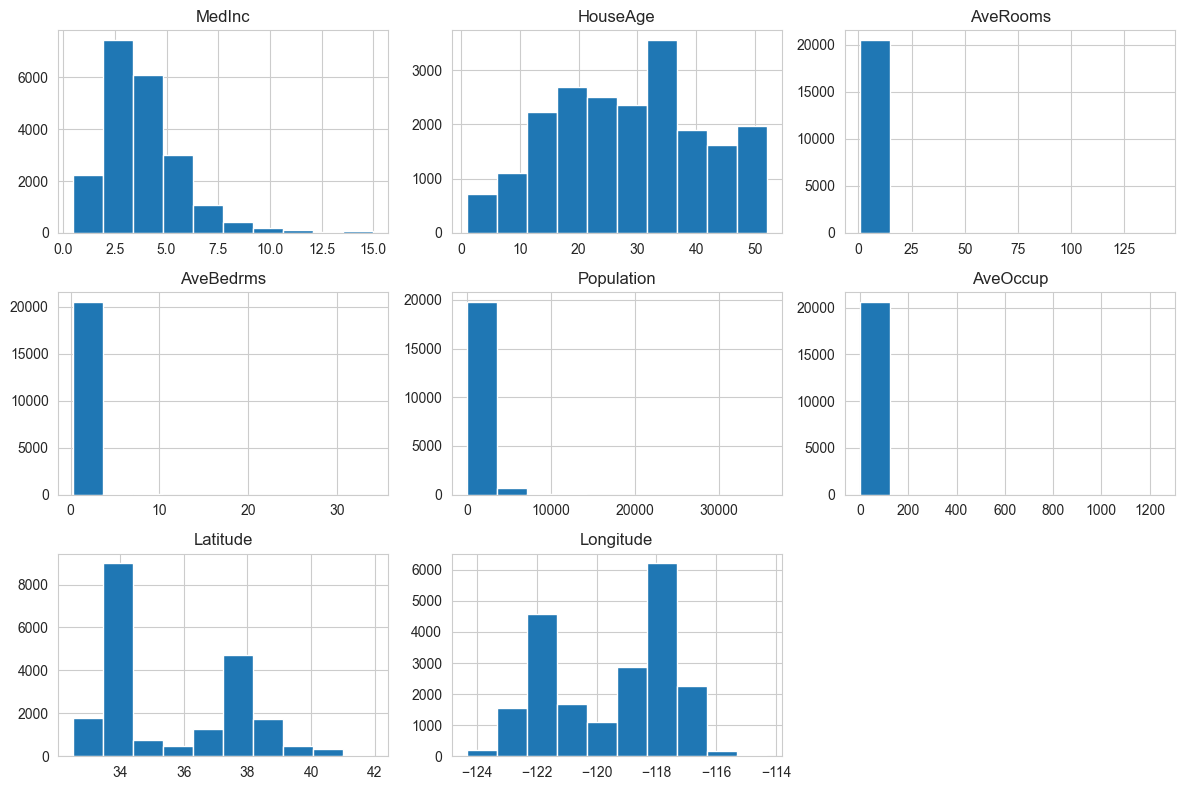

In [22]:
X.hist(figsize=(12, 8))
plt.tight_layout()
plt.show()

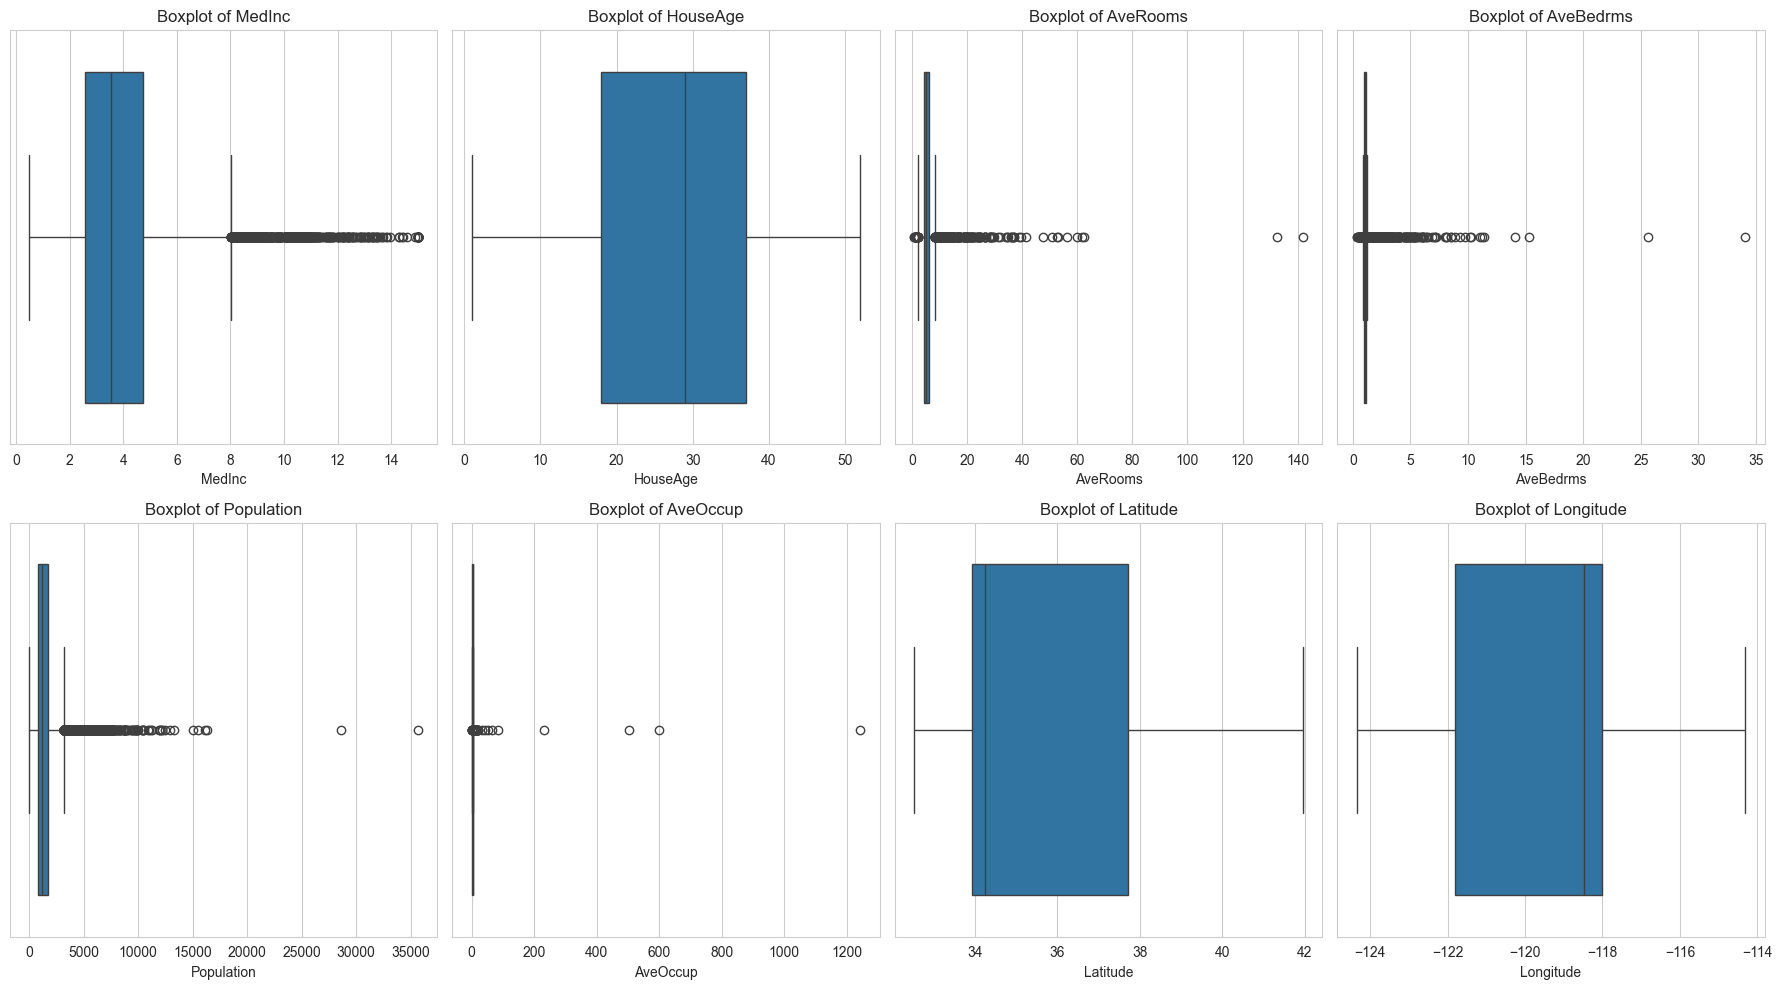

In [23]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(18, 10))

for ax, column in zip(axes.flatten(), X.columns):
    sns.boxplot(x=X[column], ax=ax)
    ax.set_title(f'Boxplot of {column}')

plt.tight_layout()
plt.show()

Признаки "AveRooms", "AveBedrooms", "AveOccup" содержат небольшое количество выбросов, которые было бы неплохо удалить:

In [24]:
X = X[(X['AveRooms'] <= 120) & 
      (X['AveBedrms'] <= 25) & 
      (X['AveOccup'] <= 200)]
y = y[X.index]

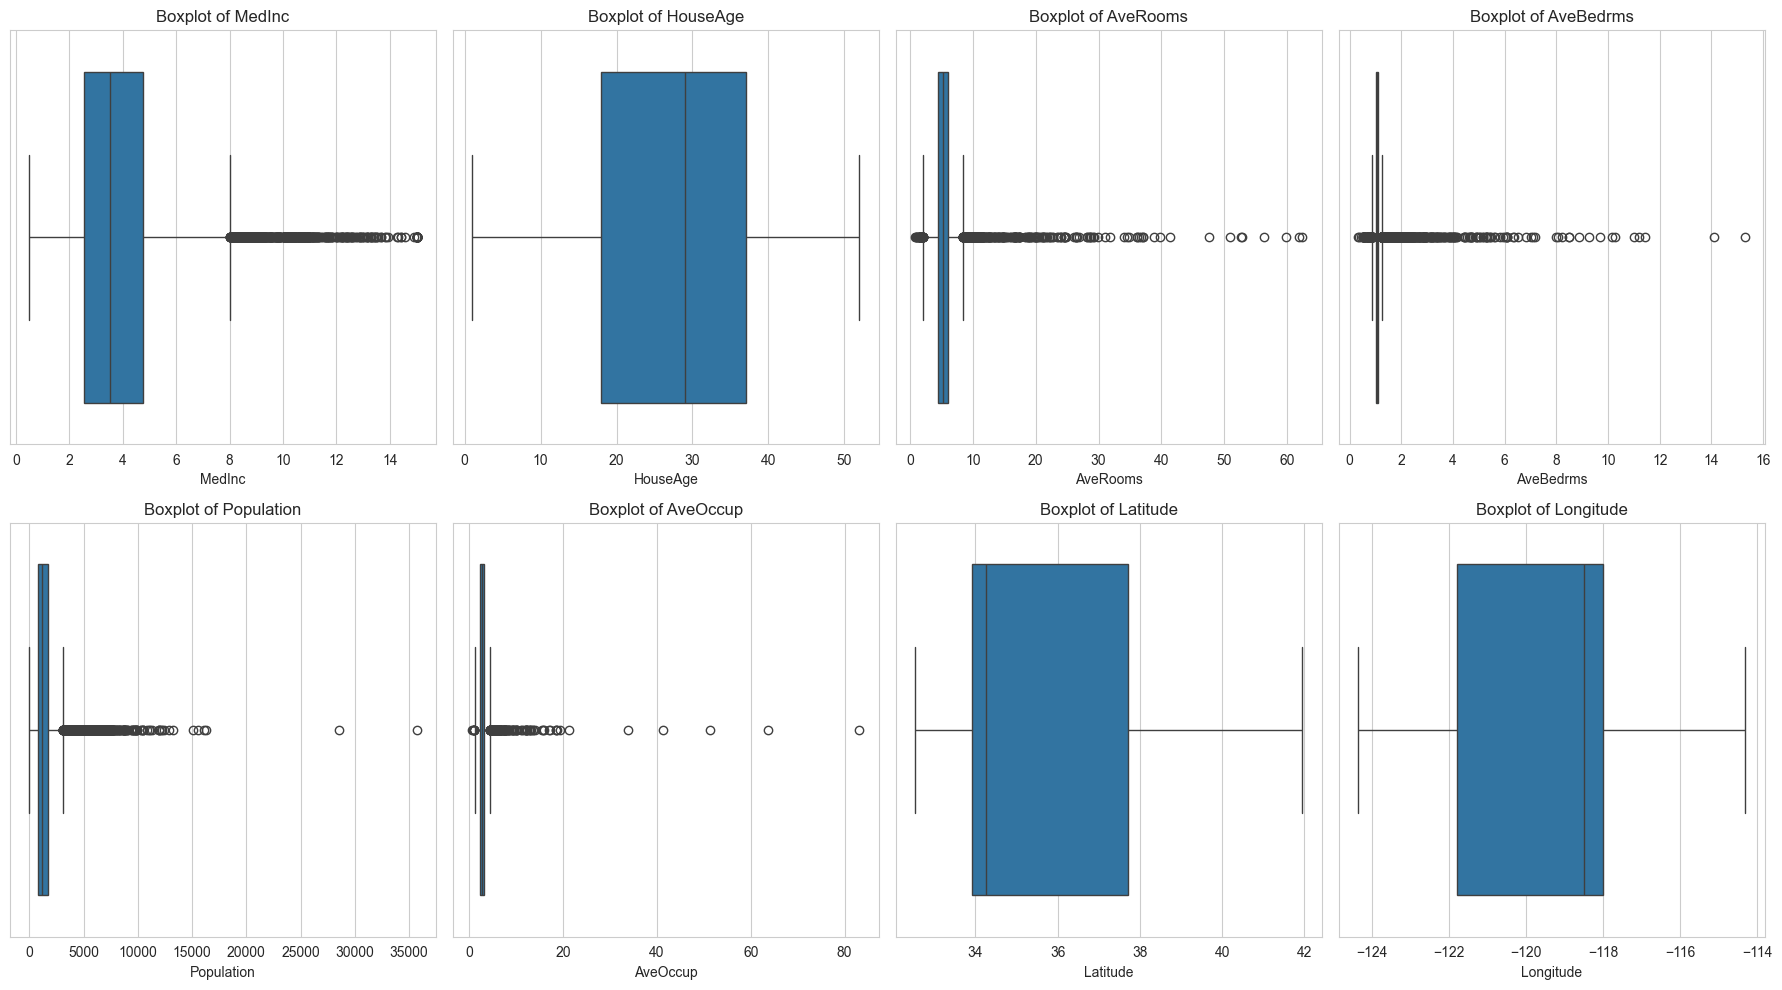

In [25]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(18, 10))

for ax, column in zip(axes.flatten(), X.columns):
    sns.boxplot(x=X[column], ax=ax)
    ax.set_title(f'Boxplot of {column}')

plt.tight_layout()
plt.show()

3. Определим, есть ли признаки, которые коррелируют друг с другом:

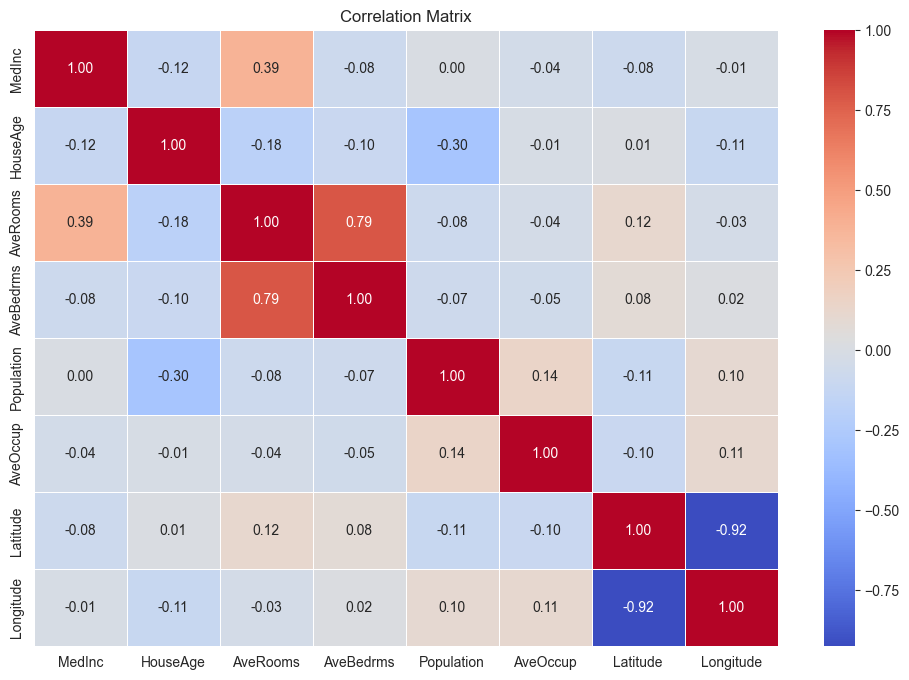

In [26]:
corr_matrix = X.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

<Figure size 1200x800 with 0 Axes>

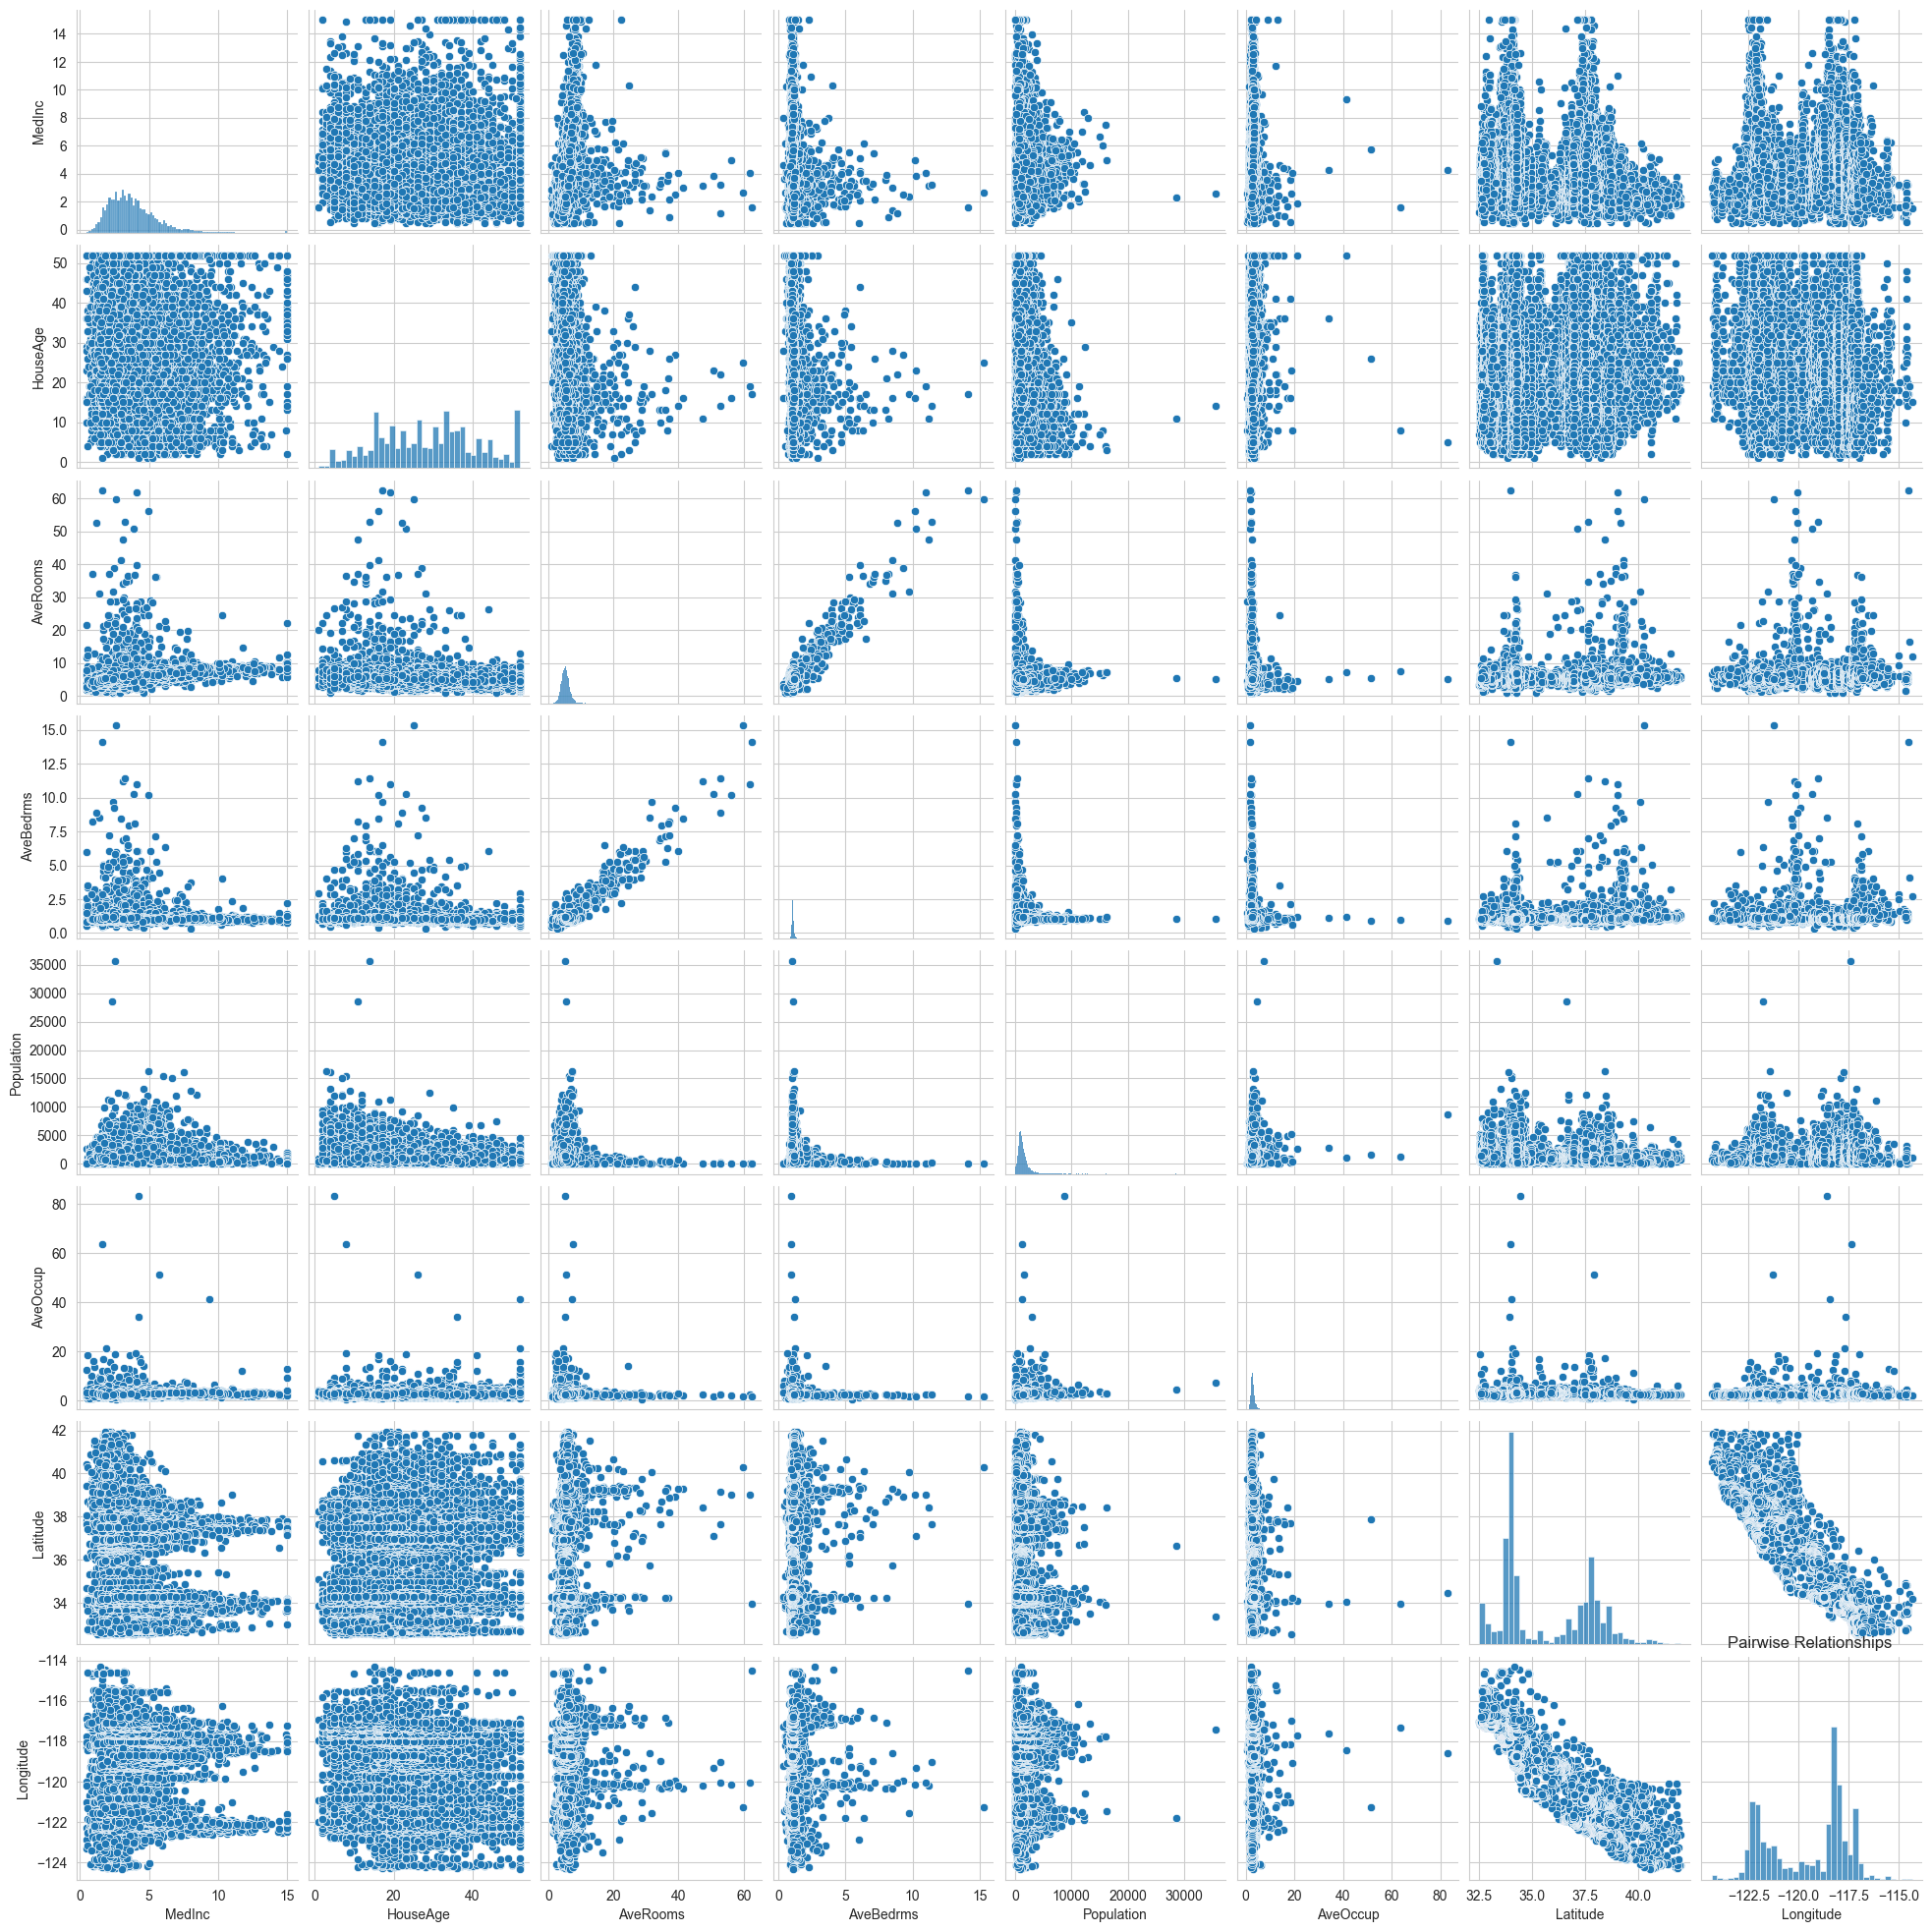

In [27]:
plt.figure(figsize=(12, 8))
sns.pairplot(X)
plt.title('Pairwise Relationships ')
plt.show()

Сразу видно, что AveRooms и AveBedrms сильно коррелируют друг с другом, как и "Latitude" с "Longitude". Уберем признаки "AveBedrms" и "Longitude":

In [28]:
X = X.drop(['AveBedrms', 'Longitude'], axis=1)

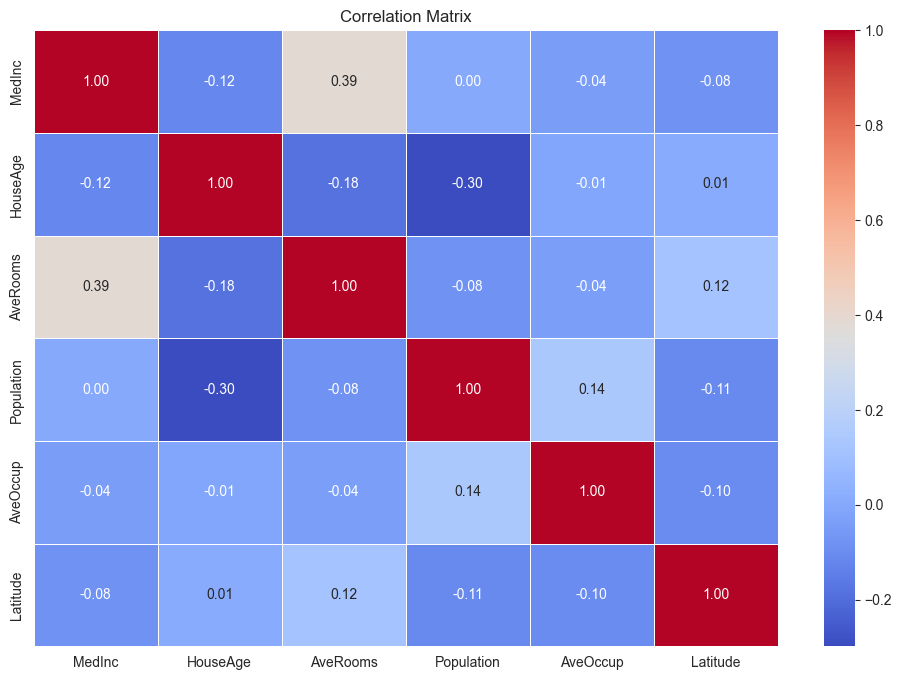

In [29]:
corr_matrix = X.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

Теперь данные готовы для построения модели линейной регресии:

In [30]:
preprocessor = ColumnTransformer(transformers=[
    ('scaler', StandardScaler(), X.columns)
])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

In [31]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE:", mse)
print("MAE:", mae)
print("R^2:", r2)

MSE: 0.6053946935103006
MAE: 0.5705830022355008
R^2: 0.5466108704290982


Было интересно посмотреть на предсказания модели, в которую мы подаем датасет с выбросами. Действительно, удаление выбросов немного улучшили нашу модель. Это можно наблюдать по меньшему MSE и MAE, а так же что R^2 для первой модели выше.

In [32]:
data = fetch_california_housing(as_frame=True)
X, y = data["data"], data["target"]
feature_names = data["feature_names"]

In [33]:
X = pd.DataFrame(data=X, columns=feature_names)
X = X.drop(['AveBedrms', 'Longitude'], axis=1)

In [34]:
preprocessor = ColumnTransformer(transformers=[
    ('scaler', StandardScaler(), X.columns)
])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE:", mse)
print("MAE:", mae)
print("R^2:", r2)

MSE: 0.6473676847426387
MAE: 0.5982706370702854
R^2: 0.5059804263462322


### Задание 3. Реализация логистической регресии (суммарно 10 баллов)

Логистическая регрессия не очень сильно отличается от обычной линейной регрессии и используется в задах классификации. Так как здесь мы снова будем пользоваться градиентным спуском, то нужно определить функцию потерь и ее градиент. Одним из самых популярных вариантов в задаче бинарной классификации является бинарная кросс-энтропия (BCE).

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Единственная проблема данной функции это возможность получить 0 под знаком логарифма, что не очень хорошо. Попробуем справить с этим "в лоб". Скажем, что наши предсказания могут принимать значения от 0 + eps до 1 - eps, где eps очень маленькое число.

#### Задание 3.1. Реализация сигмоиды (0.5 баллов)

Реализуйте функцию `sigmoid`, которая переводит действительное число $\mathbb R$ в вероятность $[0,1]$.

In [35]:
def sigmoid(output):
    # output результат X@w (-inf, +inf)
    return 1 / (1 + np.exp(-output))

#### Задание 3.2. BCE Loss и ее градиент (2.5 балла)

Так как мы с вами только начинаем изучать машинное обучение, то было бы слишком жестоко просить вас вычислить градиент BCE Loss (он не так сложен, просто нужно привыкнуть). Поэтому сразу напишем формулу для него:

$$
\nabla{\mathcal L_{BCE}(y, \hat y), X} = X^T (\sigma({\hat{y}}) - y)
$$

In [36]:
def bce(y_true, y_pred, eps=1e-15):
    """
    Функция потерь BCE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов 0/1
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели (вероятности)
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    n = y_true.shape[0]
    
    # So I want escape log(0)
    y_pred = np.clip(y_pred, eps, 1 - eps)
    
    bce_loss = - np.sum(y_true * np.log(sigmoid(y_pred)) + (1 - y_true) * np.log(1 - sigmoid(y_pred)))
    
    return bce_loss
    

def bce_grad(y_true, y_pred, X):
    """
    Функция потерь BCE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов 0/1
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели (вероятности)
        :param X: np.array[n_samples, n_features]: матрица объекты x признаки
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    n_samples = y_true.shape[0]
    gradient = np.dot(X.T, sigmoid(y_pred) - y_true)
    
    return gradient


class BCELoss:
    """
    Класс, реализующий функцию потерь BCE. Нужен для того, чтобы
    объединять в одном месте функцию потерь и градиент для нее.
    """
    
    def __call__(self, y_true, y_pred):
        return bce(y_true, y_pred)
    
    def calculate_gradient(self, y_true, y_pred, X):
        return bce_grad(y_true, y_pred, X)

#### Задание 3.3. Предсказания логистической регрессии (2 балла)

Реализуйте метод `predict` у класса `CustomLogisticRegression`, не забудьте про свободный член!

In [37]:
class CustomLogisticRegression(BaseLinearModel):
    def __init__(self, learning_rate: float = 1e-3,
                 loss_function=BCELoss(), fit_intercept=True,
                 n_iter=1000, tol=1e-5, optimizer=BasicGradientDescent, grad_norm="l1"):
        
        super().__init__(learning_rate=learning_rate,
                         loss_function=loss_function, fit_intercept=fit_intercept,
                         n_iter=n_iter, tol=tol, optimizer=optimizer, grad_norm=grad_norm)
    
    
    def predict(self, X_test):
        if self.W is None:
            raise NotFittedError("This CustomLogisticRegression instance is not fitted, run fit method.")
        
        n_test_samples = X_test.shape[0]
        if self.fit_intercept:
            ones_column = np.ones((n_test_samples, 1))
            X_test = np.hstack((ones_column, X_test))
            
        y_pred = sigmoid(np.matmul(X_test, self.W))
        return y_pred
    
    
    def __repr__(self):
        return "My custom logistic regression"

#### Снова проверим работу алгоритма на простом примере

In [38]:
# Создадим датасет из 1 признака и 2 классов
X, y = make_classification(n_features=1, n_informative=1,
                           n_redundant=0, n_clusters_per_class=1)

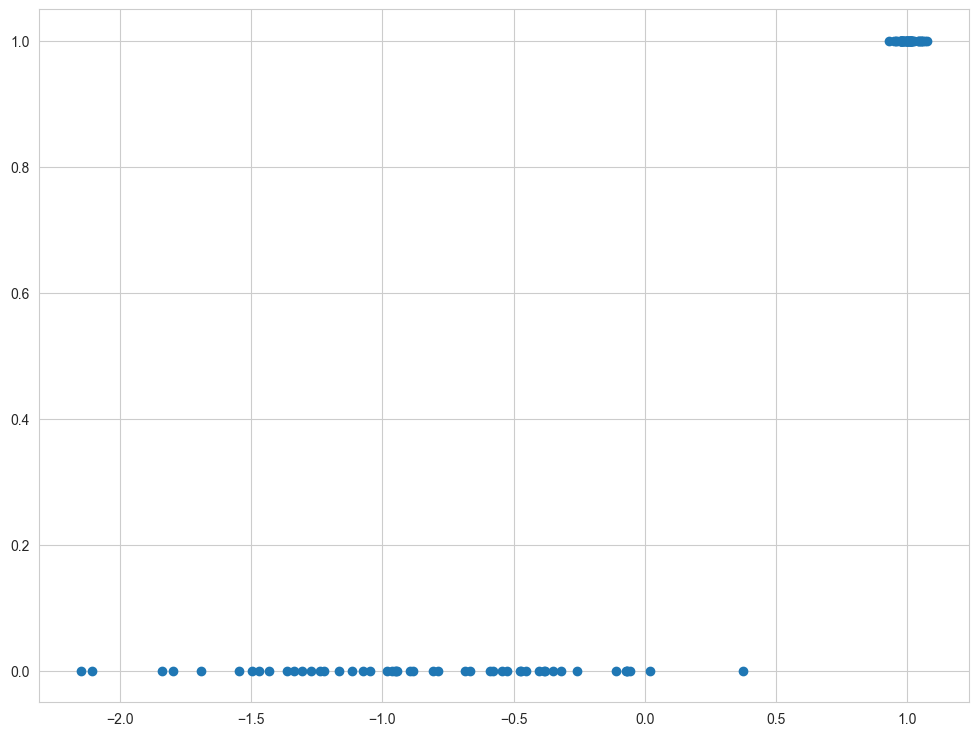

In [39]:
plt.scatter(X, y);

In [40]:
custom_log_reg = CustomLogisticRegression()
custom_log_reg.fit(X, y)
y_pred = custom_log_reg.predict(X)

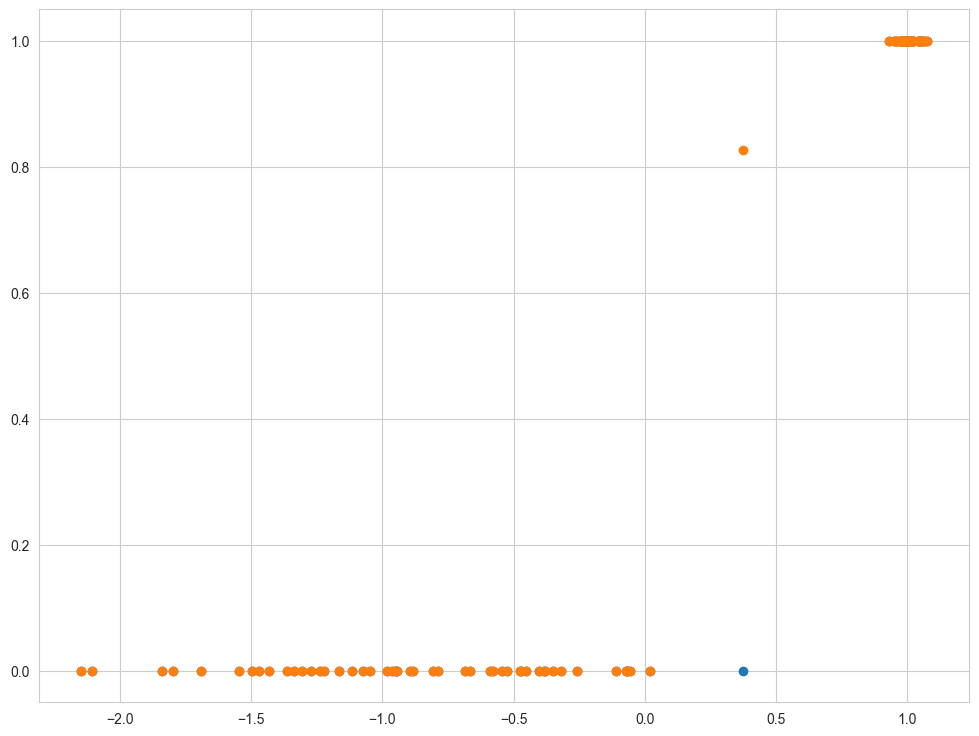

In [41]:
plt.scatter(X, y)
plt.scatter(X, y_pred);

Проверьте качество работы модели при помощи известных вам метрик бинарной классификации.

In [42]:
# Так как у нас y_pred представляет собой вероятности, преобразуем их в бинарные метки:
y_pred_binary = (y_pred >= 0.5).astype(int)

accuracy = accuracy_score(y, y_pred_binary)
precision = precision_score(y, y_pred_binary)
recall = recall_score(y, y_pred_binary)
f1 = f1_score(y, y_pred_binary)
roc_auc = roc_auc_score(y, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("ROC AUC score:", roc_auc)


Accuracy: 0.99
Precision: 0.9803921568627451
Recall: 1.0
F1-score: 0.9900990099009901
ROC AUC score: 1.0


#### Задание 3.4. Применение логистической регрессии (5 баллов)

Мы будем использовать данные по свойствам покемонов (https://www.kaggle.com/abcsds/pokemon). В данном задании вам необходимо сначала сделать краткий EDA (Посмотреть на данные и их распределения, а также посмотреть, как различные признаки связаны между собой и с целевой переменной (`Legendary`)).

In [43]:
pokemon = pd.read_csv("Pokemon.csv")
pokemon.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


#### EDA:

В нашем датасете содержатся данные, как категориальные, так и численные. Так же в колонке "Type 2" много пропущенных значений. При работе необходимо понять, какие категориальные колонки есть (#, Name, Type 1, Type 2) и какие мы точно оставим, в чем отличие типа 1 от 2. Давайте разбираться.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           800 non-null    int64 
 1   Name        800 non-null    object
 2   Type 1      800 non-null    object
 3   Type 2      414 non-null    object
 4   Total       800 non-null    int64 
 5   HP          800 non-null    int64 
 6   Attack      800 non-null    int64 
 7   Defense     800 non-null    int64 
 8   Sp. Atk     800 non-null    int64 
 9   Sp. Def     800 non-null    int64 
 10  Speed       800 non-null    int64 
 11  Generation  800 non-null    int64 
 12  Legendary   800 non-null    bool  
dtypes: bool(1), int64(9), object(3)
memory usage: 75.9+ KB


Пропущенные значения в данных:
#               0
Name            0
Type 1          0
Type 2        386
Total           0
HP              0
Attack          0
Defense         0
Sp. Atk         0
Sp. Def         0
Speed           0
Gene

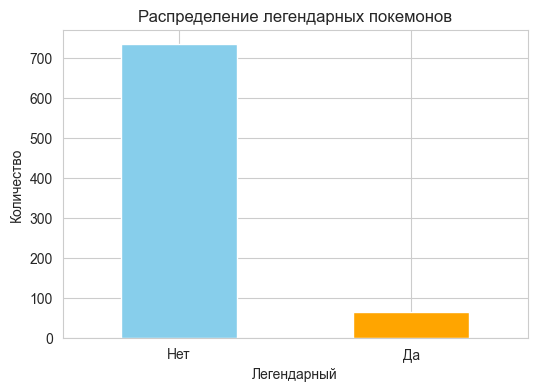

In [44]:
# EDA
pokemon.info()

print("\n")

missing_values = pokemon.isnull().sum()

print("Пропущенные значения в данных:")
print(missing_values)

# Посмотрим на переменную "Legendary"
plt.figure(figsize=(6, 4))
pokemon['Legendary'].value_counts().plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Распределение легендарных покемонов')
plt.xlabel('Легендарный')
plt.ylabel('Количество')
plt.xticks([0, 1], ['Нет', 'Да'], rotation=0)
plt.show()

Посмотрим, как распределены данные. Видно, что размерности разные, надо стандартизовать. Выбросов я не наблюдаю, так что удалять ничего не будем. По тому как распределен признак Generation можно сделать вывод, что это категориальный признак.

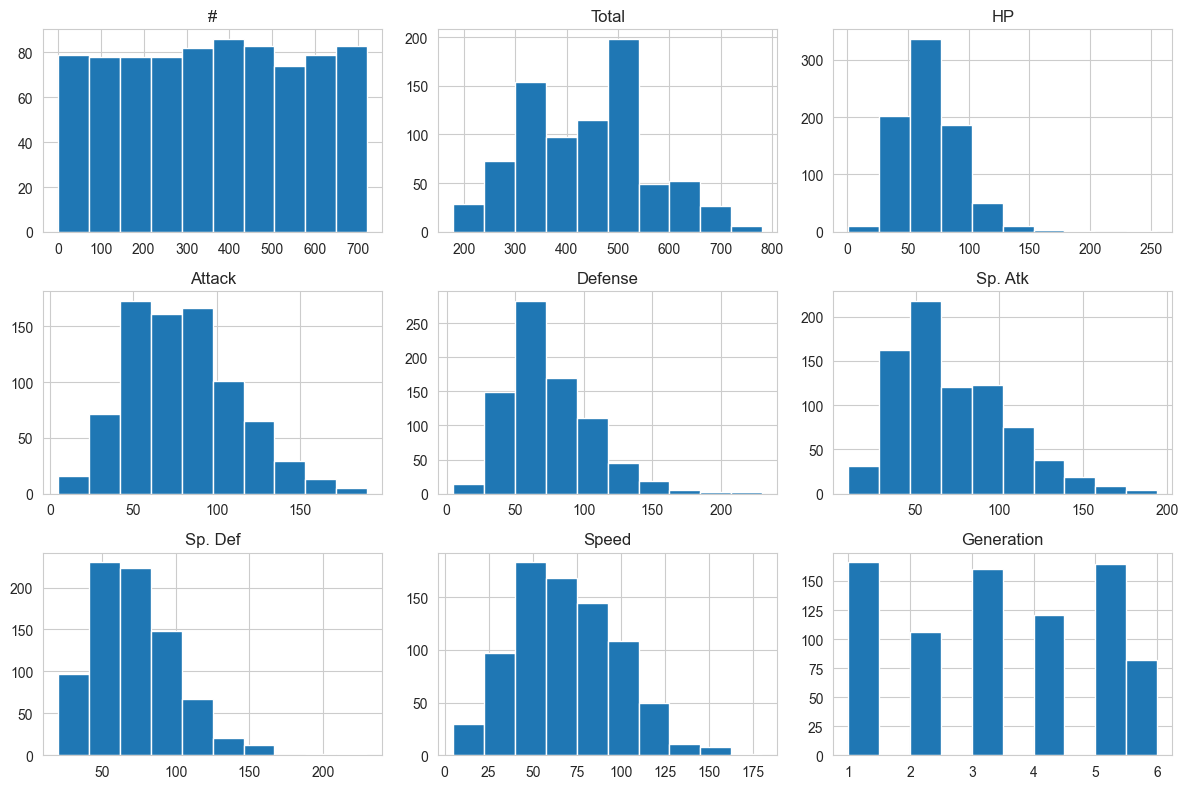

In [45]:
pokemon.hist(figsize=(12, 8))
plt.tight_layout()
plt.show()

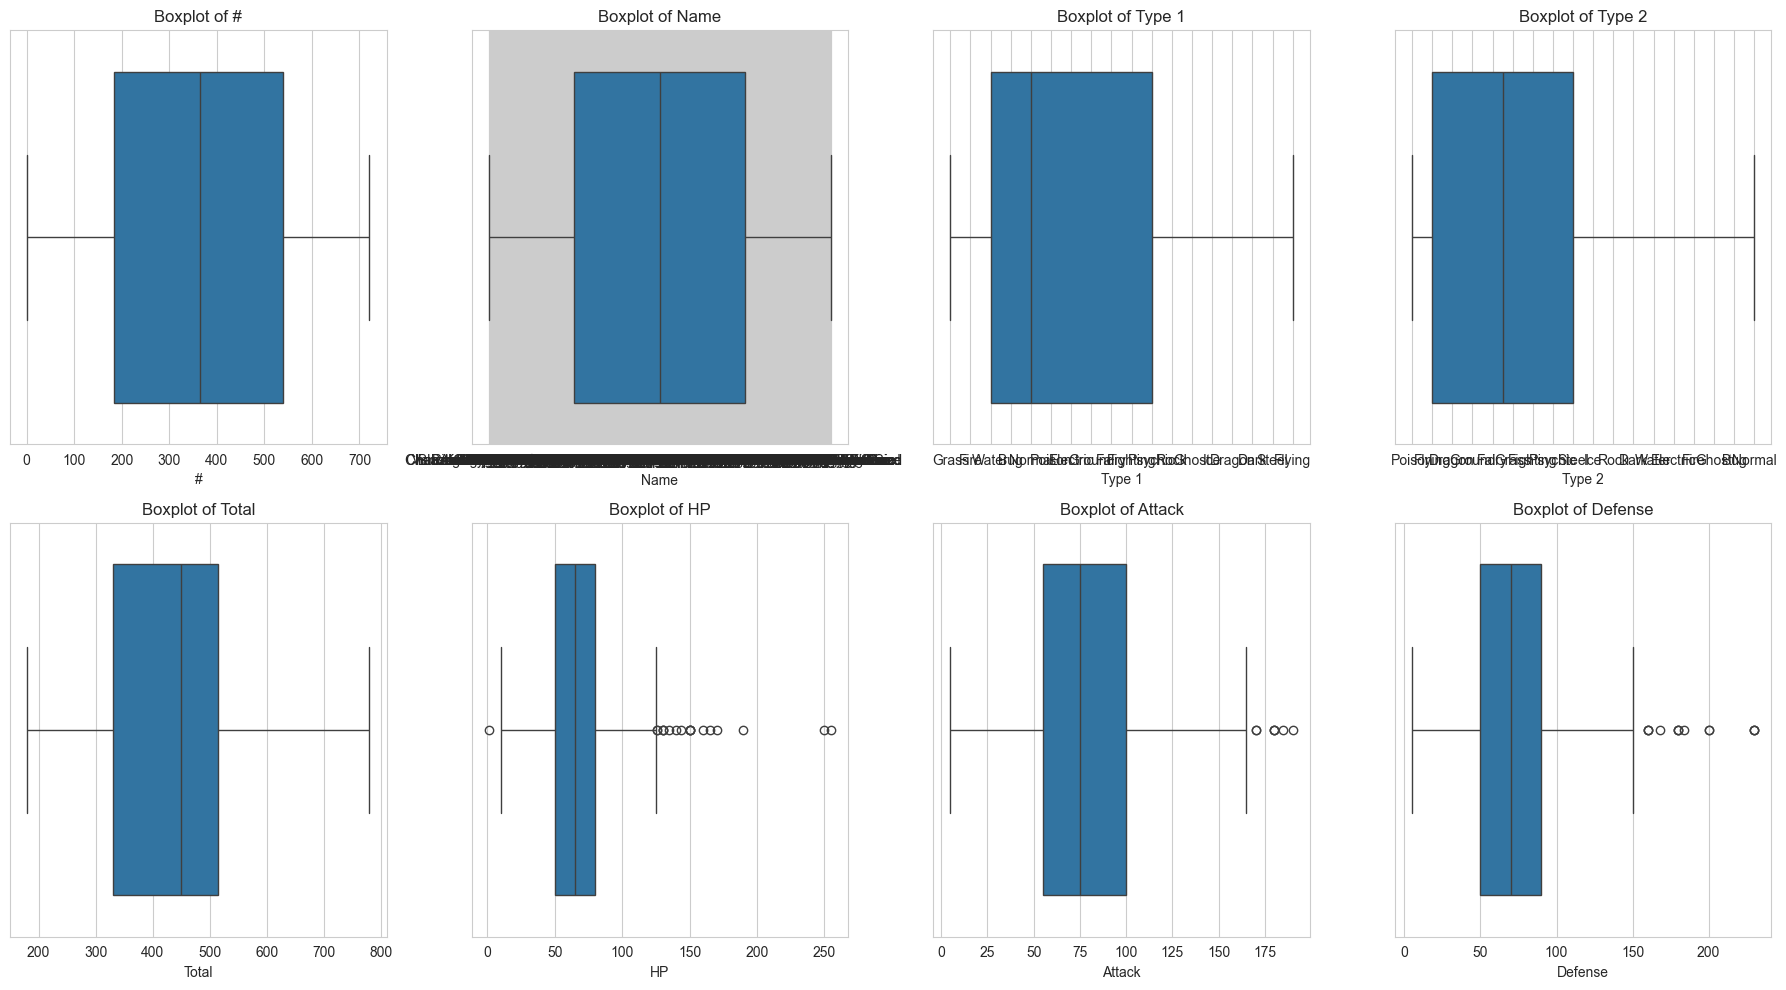

In [46]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(18, 10))

for ax, column in zip(axes.flatten(), pokemon.columns):
    sns.boxplot(x=pokemon[column], ax=ax)
    ax.set_title(f'Boxplot of {column}')

plt.tight_layout()
plt.show()

Взглянем теперь на попарную корреляцию признаков, сразу видно четкую корреляцию признака Total со всеми остальными, поэтому уберем его из нашего датасета.

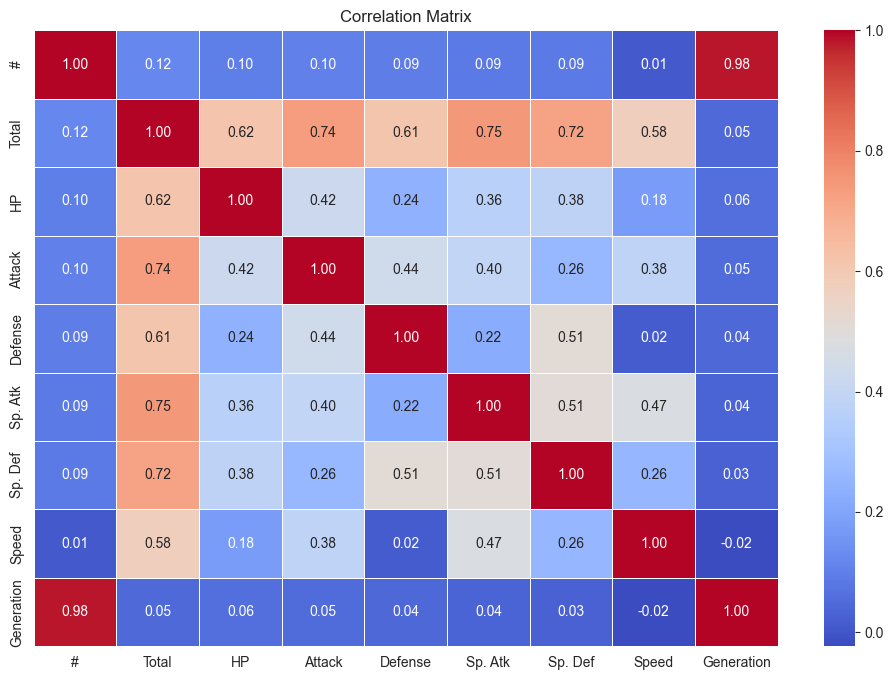

In [47]:
numeric_columns = pokemon.select_dtypes(include=['int64', 'float64'])
corr_matrix = numeric_columns.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

Мы будем предсказывать является ли покемон легендарным или нет. Замените логическое значение колонки на числовое (перекодировав на 0 и 1). Также подумайте, как в этом случае лучше закодировать категориальные признаки (может быть, лучше их просто выбросить?).

In [48]:
pokemon['Legendary'] = pokemon['Legendary'].replace({True: 1, False: 0})

C:\Users\Lenovo-ПК\AppData\Local\Temp\ipykernel_29164\1482007859.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pokemon['Legendary'] = pokemon['Legendary'].replace({True: 1, False: 0})


Теперь разберемся с каждым признаком по отдельности. Например колонка # содержит ID покемонов, в целом, можно ее так же дропнуть, как и имена. Больше всего интересует отличие Type 1 и 2 друг от друга, может быть можно что-то дропнуть или же объединить эти данные в новый признак (включает в себя два типа - 1 или 0).

In [49]:
pokemon['#'].nunique()

721

In [50]:
pokemon['Name'].nunique()

800

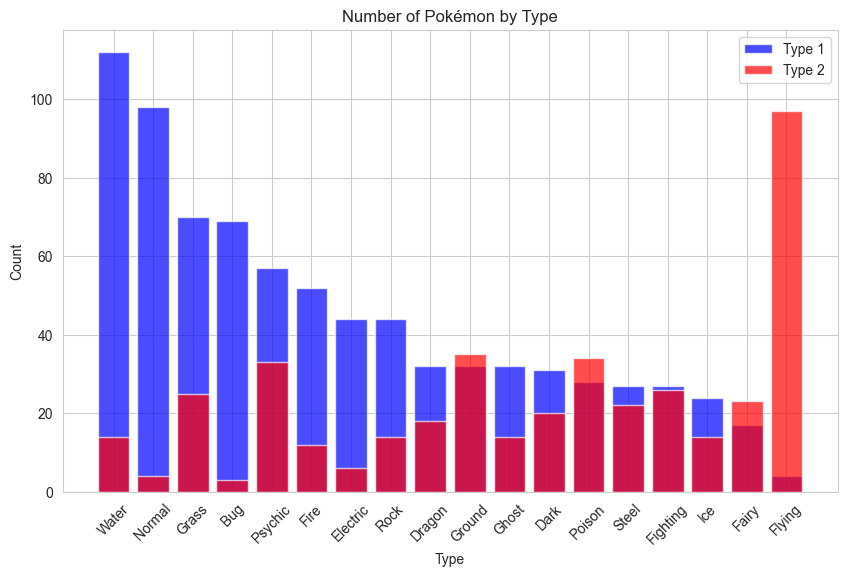

In [51]:
type1_counts = pokemon['Type 1'].value_counts()
type2_counts = pokemon['Type 2'].value_counts()

plt.figure(figsize=(10, 6))

plt.bar(type1_counts.index, type1_counts.values, color='blue', alpha=0.7, label='Type 1')
plt.bar(type2_counts.index, type2_counts.values, color='red', alpha=0.7, label='Type 2')

plt.xlabel('Type')
plt.ylabel('Count')
plt.title('Number of Pokémon by Type')
plt.xticks(rotation=45)
plt.legend()
plt.show()

Предлагаю сделать следующее. Тип 2 для кажется не сильно информативным, чтобы обучить нашу модель. Попробуем добавить новый признак "Two_types", который содержит в себе данные о том, имеет ли покемон 2 типа или нет.

In [52]:
pokemon['Two_types'] = (pokemon['Type 2'].notna()).astype(int)

Начнем работать с нашим датасетом, чтобы обучить на нем нашу модель!

In [53]:
# разделим датасет на X и y, а так же на кат. и числ. признаки
num_cols = ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']
cat_cols = ['Type 1', 'Generation', 'Two_types']

X = pokemon[['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 
            'Speed', 'Type 1', 'Generation', 'Two_types']]
y = pokemon['Legendary'].values

In [54]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),  
        ('cat', OneHotEncoder(), cat_cols)
    ])

pipeline_logreg = Pipeline([
    ('preprocessor', preprocessor),  
    ('model', LogisticRegression())  
])

Разделите ваши данные на тестовую и тренировочную выборку.

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

Обучите модель `LogisticRegression` из `sklearn`.

In [56]:
pipeline_logreg.fit(X_train, y_train)

y_pred = pipeline_logreg.predict(X_test)
y_pred_prob = pipeline_logreg.predict_proba(X_test)

Выведите метрики вашего классификатора:

1. Нарисуйте [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html).

2. Изобразите ROC кривую и посчитайте площадь под ней.

3. Скажите, какие признаки оказались наиболее важны для модели.

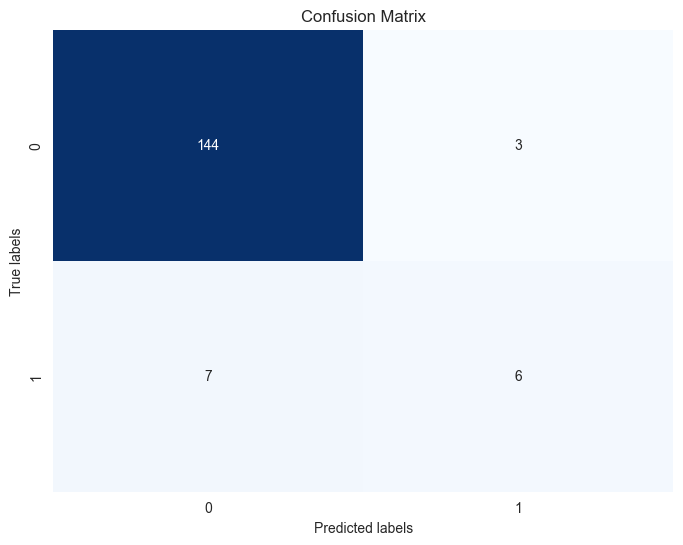

In [57]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

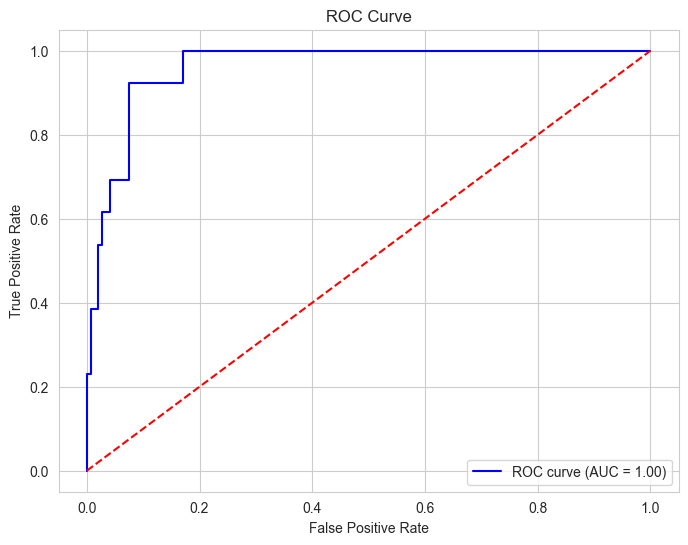

AUC-ROC: 0.9602302459445318


In [58]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:,1])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

roc_auc = roc_auc_score(y_test, y_pred_prob[:,1])
print("AUC-ROC:", roc_auc)

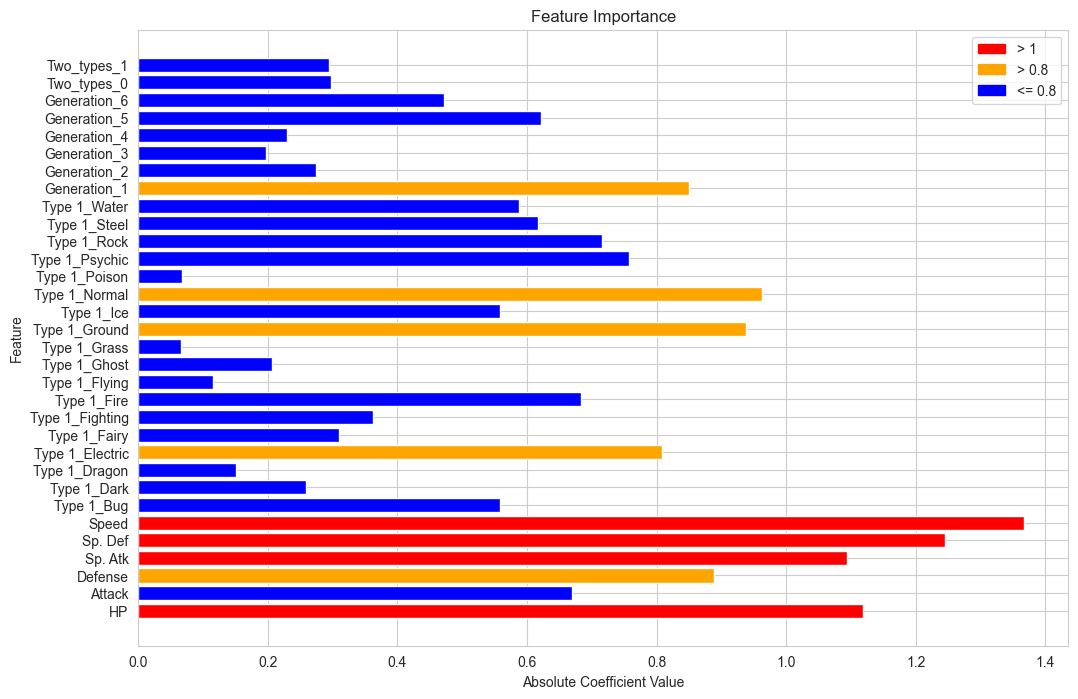

In [59]:
# Рассмотрим абсолютные значения коэффициентов, чтобы понять, какие признаки имеют больший вклад
encoded_cat_cols = list(pipeline_logreg.named_steps['preprocessor'].named_transformers_['cat']
                        .get_feature_names_out(input_features=cat_cols))

feature_names = num_cols + encoded_cat_cols
coefficients = pipeline_logreg.named_steps['model'].coef_[0]

plt.figure(figsize=(12, 8))
colors = np.where(abs(coefficients) > 1, 'red', 
                  np.where(abs(coefficients) > 0.8, 'orange', 'blue'))
plt.barh(feature_names, abs(coefficients), color=colors)
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Importance')
legend_labels = ['> 1', '> 0.8', '<= 0.8']
legend_handles = [plt.Rectangle((0,0),1,1, color=color) for color in ['red', 'orange', 'blue']]
plt.legend(legend_handles, legend_labels)

plt.grid(True)
plt.show()

Если подытожить, на мой взгляд модель предсказывает хорошо (ROC AUC = 0.96). В Confusion matrix видно такой же дисбаланс, так как легендарных было больше в разы, чем нелегендарных.

По последнему графику можно выделить 4 основных признака, которые имеют больший вклад: Speed, special attack, the base damage resistance against special attacks and health; при этом заметим, что некоторые категории из Типа 1 так же оказались хоть и не самыми важными, но и не самыми бесполезными (Normal, Ground, Electric). Так же на легендарность влияет нанесенный урон (Defense) и 1е поколение покемонов.

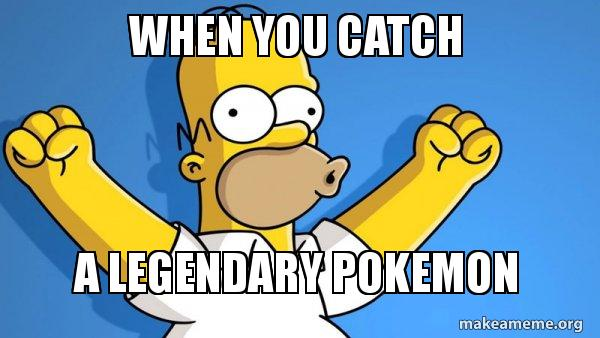

In [60]:
from IPython.display import Image

image_path = "./81330when-you-catch-59de4d.jpg"
Image(filename=image_path)

### Задание 4. Расскажите о вашей любимой музыкальной группе (исполнителе) (0.5 балла)

Расскажите, как вы познакомились с этой группой и скиньте несколько наиболее любимых треков)

Группа ZOLOTO! Долгое время я противилась слушать ее, пока Маша Узун не пришла ко мне в гости делать практикум. После этого Маша показала мне все их клипы, я влюбилась, и вот теперь мы вместе с ней идем на их концерт в апреле, присоединяйтесь!

Советую PMML (https://youtu.be/vemK9AqTfHg?si=H7BoBEXHi9fhZh08) и останемся здесь (https://youtu.be/z16XHu6LCDI?si=tqr50JI_xX9sIwjX)

А вообще их очень классно орать за рулем, по крайней мере точно безопаснее, чем водить под скриптонита (https://youtu.be/nkncpcanly0?si=8BKH4vjvxZnvFVah)

## Therapy time

Напишите здесь ваши впечатления о задании: было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз. 

**Ваши мысли:**

Во-первых, теперь у меня есть крутая причина отказывать парням в свиданиях, потому что "я делаю домашку по машинному обучению" звучит одновременно круто и не оставляет выбора людям, а я наслаждаюсь спокойствием дома (хотя с домашка по МЛ это сложно назвать спокойствием, но меня устраивает) :D

А вообще первая часть снова взорвала мне мозг, после которой осталось много вопросов, как понять, что я делаю все так. Хотелось бы видеть референсы хорошего и подробного EDA, потому что пока для меня не очень понятно, что конкретно от меня хотят видеть, ноутбук как на кегле или же минимальный набор анализа данных, чтобы делать вывобы по поводу оставлять/выбрасывать данные, как из преобразовывать и тд. Понравилось работать с датасетами самостоятельно и смотреть, что из этого получается, но к формулам все еще много вопросов и недопонимания :(